In [15]:
# Cell 1: imports
import math
import numpy as np
import random
from copy import deepcopy

In [16]:
#cell 2: connect 4 definitions and minimax agent
class Connect4:
    def __init__(self, rows=6, cols=7, connect=4):
        self.rows = rows
        self.cols = cols
        self.connect = connect
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1  # 1 = X, -1 = O
        self.last_move = None
        self.done = False
        self.winner = None
        return self.board.copy()

    def valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def step(self, action):
        if action not in self.valid_actions():
            raise ValueError("Invalid action")

        # drop piece
        for r in range(self.rows - 1, -1, -1):
            if self.board[r, action] == 0:
                self.board[r, action] = self.current_player
                self.last_move = (r, action)
                break

        winner = check_winner(self.board, self.connect, self.last_move)
        if winner is not None:
            self.done = True
            self.winner = winner
            reward = 1 if winner == self.current_player else -1
        elif np.all(self.board != 0):
            self.done = True
            self.winner = 0
            reward = 0
        else:
            reward = 0

        if not self.done:
            self.current_player *= -1

        return self.board.copy(), reward, self.done, {}

    def render(self):
        sym = {1: 'X', -1: 'O', 0: '.'}
        for r in range(self.rows):
            print(" ".join(sym[int(x)] for x in self.board[r]))
        print(" ".join(str(i) for i in range(self.cols)))
        print()

def check_winner(board, connect=4, last_move=None):
    rows, cols = board.shape

    if last_move is not None:
        r0, c0 = last_move
        player = board[r0, c0]
        if player == 0:
            return None

        dirs = [(1,0), (0,1), (1,1), (-1,1)]
        for dr, dc in dirs:
            count = 1

            rr, cc = r0 + dr, c0 + dc
            while 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == player:
                count += 1
                rr += dr; cc += dc

            rr, cc = r0 - dr, c0 - dc
            while 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == player:
                count += 1
                rr -= dr; cc -= dc

            if count >= connect:
                return player

        return None

    for r in range(rows):
        for c in range(cols):
            if board[r,c] == 0:
                continue
            player = board[r,c]
            for dr, dc in [(1,0),(0,1),(1,1),(-1,1)]:
                cnt = 0
                rr, cc = r, c
                while 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == player:
                    cnt += 1
                    rr += dr; cc += dc
                if cnt >= connect:
                    return player
    return None

def heuristic_evaluate(board, player):
    rows, cols = board.shape
    opponent = -player

    SCORE = {4: 100000, 3: 100, 2: 10}
    total = 0

    def score_window(window):
        s = 0
        cnt_p = np.count_nonzero(window == player)
        cnt_o = np.count_nonzero(window == opponent)
        cnt_e = np.count_nonzero(window == 0)

        if cnt_p == 4:
            s += SCORE[4]
        elif cnt_p == 3 and cnt_e == 1:
            s += SCORE[3]
        elif cnt_p == 2 and cnt_e == 2:
            s += SCORE[2]

        if cnt_o == 4:
            s -= SCORE[4]
        elif cnt_o == 3 and cnt_e == 1:
            s -= SCORE[3]*0.9
        elif cnt_o == 2 and cnt_e == 2:
            s -= SCORE[2]*0.5

        return s

    # horizontal
    for r in range(rows):
        for c in range(cols-3):
            window = board[r, c:c+4]
            total += score_window(window)

    # vertical
    for c in range(cols):
        for r in range(rows-3):
            window = board[r:r+4, c]
            total += score_window(window)

    # diag down-right
    for r in range(rows-3):
        for c in range(cols-3):
            window = np.array([board[r+i, c+i] for i in range(4)])
            total += score_window(window)

    # diag up-right
    for r in range(3, rows):
        for c in range(cols-3):
            window = np.array([board[r-i, c+i] for i in range(4)])
            total += score_window(window)

    # center column preference
    center = cols // 2
    total += np.count_nonzero(board[:, center] == player) * 3

    return total

def minimax_ab(board, depth, alpha, beta, maximizing, player_to_move, env):
    w = check_winner(board, env.connect, last_move=None)
    if w is not None:
        return (1e9 if w == 1 else -1e9), None
    if np.all(board != 0):
        return 0, None
    if depth == 0:
        return heuristic_evaluate(board, player_to_move), None

    valid_moves = [c for c in range(env.cols) if board[0, c] == 0]
    valid_moves.sort(key=lambda c: -abs(c - env.cols//2))  # center-first move ordering

    best_move = None

    if maximizing:
        value = -math.inf
        for col in valid_moves:
            new_board = board.copy()
            for r in range(env.rows-1, -1, -1):
                if new_board[r, col] == 0:
                    new_board[r, col] = player_to_move
                    last_r = r
                    break

            w = check_winner(new_board, env.connect, last_move=(last_r, col))
            if w is not None:
                v = 1e9
            else:
                v, _ = minimax_ab(new_board, depth-1, alpha, beta, False, -player_to_move, env)

            if v > value:
                value = v
                best_move = col

            alpha = max(alpha, value)
            if alpha >= beta:
                break

        return value, best_move

    else:
        value = math.inf
        for col in valid_moves:
            new_board = board.copy()
            for r in range(env.rows-1, -1, -1):
                if new_board[r, col] == 0:
                    new_board[r, col] = player_to_move
                    last_r = r
                    break

            w = check_winner(new_board, env.connect, last_move=(last_r, col))
            if w is not None:
                v = -1e9
            else:
                v, _ = minimax_ab(new_board, depth-1, alpha, beta, True, -player_to_move, env)

            if v < value:
                value = v
                best_move = col

            beta = min(beta, value)
            if alpha >= beta:
                break

        return value, best_move
    
def minimax_agent(env, depth=4):
    board = env.board.copy()
    player = env.current_player
    value, action = minimax_ab(board, depth, -math.inf, math.inf, True, player, env)
    if action is None:
        return random.choice(env.valid_actions())
    return action


In [ ]:
#Cell 3: game loop human vs AI(minimax)
env = Connect4()
game_over = False

print("Starting Connect Four")
env.render()

# 0 = Human, 1 = AI
turn = 0

while not game_over:

    if turn == 0:
        # Human move
        valid = env.valid_actions()
        col = None
        while col not in valid:
            try:
                col_input = int(input(f"Your move {valid}: "))
                if col_input in valid:
                    col = col_input
                else:
                    print("Invalid column. Choose from", valid)
            except:
                print("Enter a valid integer column.")
        
        _, _, game_over, _ = env.step(col)

        if env.winner == 1:
            env.render()
            print("You win!")
            break

    else:
        # AI move using minimax
        print("AI thinking...")
        col = minimax_agent(env, depth=4)
        _, _, game_over, _ = env.step(col)

        if env.winner == -1:
            env.render()
            print("AI wins!")
            break

    env.render()
    turn = 1 - turn  # switch turns

    # Check draw
    if game_over and env.winner == 0:
        print("Draw!")
        break

Starting Connect Four
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X . . . . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X . . O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X . X O . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
X . X O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . . O . . .
X . X O . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . O O . . .
X . X O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
X . O O . . .
X . X O . . .
0 1 2 3 4 5 6

AI thinking...
. . . . . . .
. . . . . . .
. . . . . . .
O . . X . . .
X . O O . . .
X . X O . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .

In [32]:
# ==========================
# Cell 4: Train Linear Agent (Procedural) with epsilon param
# ==========================

import numpy as np
import random
import math

# --------------------------
# Agent Parameters
# --------------------------
weights = np.zeros(6)  # [Bias, My3, My2, Opp3, Opp2, Center]
alpha = 0.01
gamma = 0.9
epsilon_min = 0.05
epsilon_decay = 0.99995

# --------------------------
# Features Extraction
# --------------------------
def get_features(board, player):
    opp = -player
    my_3 = my_2 = opp_3 = opp_2 = 0
    rows, cols = board.shape

    def check(window):
        nonlocal my_3, my_2, opp_3, opp_2
        cnt_p = np.count_nonzero(window == player)
        cnt_o = np.count_nonzero(window == opp)
        cnt_e = np.count_nonzero(window == 0)
        if cnt_p == 3 and cnt_e == 1: my_3 += 1
        elif cnt_p == 2 and cnt_e == 2: my_2 += 1
        if cnt_o == 3 and cnt_e == 1: opp_3 += 1
        elif cnt_o == 2 and cnt_e == 2: opp_2 += 1

    # Horizontal
    for r in range(rows):
        for c in range(cols-3):
            check(board[r, c:c+4])
    # Vertical
    for c in range(cols):
        for r in range(rows-3):
            check(board[r:r+4, c])
    # Diagonals
    for r in range(rows-3):
        for c in range(cols-3):
            check([board[r+i, c+i] for i in range(4)])
            check([board[r+3-i, c+i] for i in range(4)])

    center_ctrl = np.count_nonzero(board[:, cols//2] == player)
    return np.array([1.0, my_3, my_2, opp_3, opp_2, center_ctrl])

# --------------------------
# Evaluate Board
# --------------------------
def evaluate(board, player):
    return np.dot(weights, get_features(board, player))

# --------------------------
# Choose Action (Epsilon-Greedy)
# --------------------------
def choose_action(env, epsilon_current=1.0, training=True):
    valid = env.valid_actions()
    if not valid: return None

    if training and random.random() < epsilon_current:
        return random.choice(valid)

    best_val = -float('inf')
    best_act = random.choice(valid)
    for act in valid:
        temp_board = env.board.copy()
        for r in range(env.rows-1, -1, -1):
            if temp_board[r, act] == 0:
                temp_board[r, act] = env.current_player
                break
        val = evaluate(temp_board, env.current_player)
        if val > best_val:
            best_val = val
            best_act = act
    return best_act

# --------------------------
# Update Weights
# --------------------------
def update(prev_board, action, reward, next_board, done, player):
    global weights
    after_board = prev_board.copy()
    for r in range(6-1, -1, -1):
        if after_board[r, action] == 0:
            after_board[r, action] = player
            break
    features = get_features(after_board, player)
    current_val = np.dot(weights, features)
    if done:
        target = reward
    else:
        target = reward + gamma * evaluate(next_board, player)
    error = target - current_val
    weights += alpha * error * features

# --------------------------
# Linear Agent Move (Greedy Evaluation)
# --------------------------
def linear_agent_move(env, weights):
    valid = env.valid_actions()
    if not valid: 
        return None

    best_val = -float('inf')
    best_act = random.choice(valid)

    for act in valid:
        temp_board = env.board.copy()
        for r in range(env.rows-1, -1, -1):
            if temp_board[r, act] == 0:
                temp_board[r, act] = env.current_player
                break
        # Feature extraction
        opp = -env.current_player
        my_3 = my_2 = opp_3 = opp_2 = 0
        rows, cols = temp_board.shape

        def check(window):
            nonlocal my_3, my_2, opp_3, opp_2
            cnt_p = np.count_nonzero(window == env.current_player)
            cnt_o = np.count_nonzero(window == opp)
            cnt_e = np.count_nonzero(window == 0)
            if cnt_p == 3 and cnt_e == 1: my_3 += 1
            elif cnt_p == 2 and cnt_e == 2: my_2 += 1
            if cnt_o == 3 and cnt_e == 1: opp_3 += 1
            elif cnt_o == 2 and cnt_e == 2: opp_2 += 1

        # Horizontal
        for r_idx in range(rows):
            for c_idx in range(cols-3):
                check(temp_board[r_idx, c_idx:c_idx+4])
        # Vertical
        for c_idx in range(cols):
            for r_idx in range(rows-3):
                check(temp_board[r_idx:r_idx+4, c_idx])
        # Diagonals
        for r_idx in range(rows-3):
            for c_idx in range(cols-3):
                check([temp_board[r_idx+i, c_idx+i] for i in range(4)])
                check([temp_board[r_idx+3-i, c_idx+i] for i in range(4)])
        # Center
        center_ctrl = np.count_nonzero(temp_board[:, cols//2] == env.current_player)
        features = np.array([1.0, my_3, my_2, opp_3, opp_2, center_ctrl])
        val = np.dot(weights, features)

        if val > best_val:
            best_val = val
            best_act = act

    return best_act

# --------------------------
# Training Loop
# --------------------------
def train(episodes=3000, epsilon_start=1.0):
    global weights
    weights = np.zeros(6)
    env = Connect4()
    epsilon_current = epsilon_start
    wins = 0
    losses = 0

    for ep in range(1, episodes+1):
        env.reset()
        # Randomize who goes first
        if random.random() < 0.5:
            opp_act = random.choice(env.valid_actions())
            env.step(opp_act)

        done = False
        while not done:
            state_before = env.board.copy()
            action = choose_action(env, epsilon_current)
            _, reward, done, _ = env.step(action)
            state_after = env.board.copy()
            if done:
                update(state_before, action, reward, state_after, done, 1)
                if reward == 1: wins += 1
                break

            # Opponent move (Minimax or Random)
            if random.random() < 0.3:
                opp_action = random.choice(env.valid_actions())
            else:
                opp_action = minimax_agent(env, depth=2)
                if isinstance(opp_action, tuple):
                    opp_action = opp_action[0]
            _, reward_opp, done, _ = env.step(opp_action)
            state_final = env.board.copy()
            if done:
                r = -1 if env.winner == -1 else 0
                update(state_before, action, r, state_final, done, 1)
                if r == -1: losses += 1
            else:
                update(state_before, action, 0, state_final, done, 1)

        # Decay epsilon
        epsilon_current = max(epsilon_min, epsilon_current * epsilon_decay)

        if ep % 500 == 0:
            print(f"Ep {ep}: Wins {wins}, Losses {losses}, Epsilon {epsilon_current:.3f}")
            print(f"Weights: {np.round(weights, 3)}")
            wins = 0
            losses = 0

    return weights

# --------------------------
# Train the Agent
# --------------------------
trained_agent_weights = train(episodes=3000, epsilon_start=1.0)


Ep 500: Wins 10, Losses 251, Epsilon 0.975
Weights: [-0.5    0.148  0.023 -0.167 -0.13   0.034]
Ep 1000: Wins 12, Losses 231, Epsilon 0.951
Weights: [-0.535  0.162  0.078 -0.161 -0.133  0.035]
Ep 1500: Wins 19, Losses 235, Epsilon 0.928
Weights: [-0.471  0.101  0.02  -0.169 -0.101  0.041]
Ep 2000: Wins 13, Losses 229, Epsilon 0.905
Weights: [-0.485  0.134  0.035 -0.17  -0.09   0.028]
Ep 2500: Wins 17, Losses 214, Epsilon 0.882
Weights: [-0.453  0.127  0.031 -0.221 -0.096 -0.006]
Ep 3000: Wins 18, Losses 234, Epsilon 0.861
Weights: [-0.43   0.11   0.027 -0.211 -0.092  0.007]


In [33]:
# ==========================
# Cell 5: Game loop Human vs Linear Agent
# ==========================

env = Connect4()
game_over = False
turn = 0  # 0 = human, 1 = Linear Agent

print("Play against trained Linear Agent")
env.render()


# --------------------------
# Game Loop
# --------------------------
while not game_over:
    if turn == 0:
        # Human move
        valid = env.valid_actions()
        col = None
        while col not in valid:
            try:
                col_input = int(input(f"Your move {valid}: "))
                if col_input in valid:
                    col = col_input
            except:
                pass
        _, _, game_over, _ = env.step(col)

    else:
        # Linear Agent move
        col = linear_agent_move(env, trained_agent_weights)
        _, _, game_over, _ = env.step(col)

    env.render()
    turn = 1 - turn

    if game_over:
        if env.winner == 1:
            print("Human wins!")
        elif env.winner == -1:
            print("AI wins!")
        else:
            print("Draw!")

Play against trained Linear Agent
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
X . . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
X O . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. X . O . . .
X O . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. X . O . . .
X O . X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. X . O . . .
X O X X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . . . . .
. . . O . . .
. . . O . . .
. X . O . . .
X O X X . . .
0 1 2 3 4 5 6

. . . . . . .
. . . X . . .
. . . O . . .
. . . O . . .
. X . O . . .
X O X

In [ ]:
#cell 6: minimax vs q-learning
num_simulations = 100  # number of games to simulate
ai1_wins = 0
ai2_wins = 0
draws = 0

# Optional: you can replace ai1_action and ai2_action with minimax_agent if you want a comparison
for sim in range(num_simulations):
    env = Connect4()
    game_over = False
    turn = 0  # 0 = Q-learning AI (ai1), 1 = Q-learning AI (ai2)

    while not game_over:
        if turn == 0:
            col = minimax_agent(env)
            _, _, game_over, _ = env.step(col)
        else:
            col = q_agent(env)
            _, _, game_over, _ = env.step(col)

        turn = 1 - turn

    if env.winner == 1:
        ai1_wins += 1
    elif env.winner == -1:
        ai2_wins += 1
    else:
        draws += 1

print(f"After {num_simulations} games:")
print(f"AI1 wins: {ai1_wins} ({ai1_wins/num_simulations*100:.1f}%)")
print(f"AI2 wins: {ai2_wins} ({ai2_wins/num_simulations*100:.1f}%)")
print(f"Draws   : {draws} ({draws/num_simulations*100:.1f}%)")

import matplotlib.pyplot as plt

labels = ['AI1', 'AI2', 'Draws']
counts = [ai1_wins, ai2_wins, draws]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['blue','red','gray'])
plt.title('Q-learning Self-play Results')
plt.ylabel('Number of Games Won')
plt.show()

After 100 games:
AI1 wins: 100 (100.0%)
AI2 wins: 0 (0.0%)
Draws   : 0 (0.0%)


Training Linear Agent with epsilon=1.0
Ep 500: Wins 15, Losses 238, Epsilon 0.975
Weights: [-0.511  0.164  0.03  -0.173 -0.123 -0.006]
Ep 1000: Wins 19, Losses 227, Epsilon 0.951
Weights: [-0.475  0.135  0.067 -0.154 -0.078 -0.015]
Ep 1500: Wins 11, Losses 248, Epsilon 0.928
Weights: [-0.491  0.18   0.014 -0.152 -0.111  0.009]
Ep 2000: Wins 12, Losses 248, Epsilon 0.905
Weights: [-0.508  0.138  0.047 -0.163 -0.06   0.026]
Epsilon 1.0 win rate: 0.79
Training Linear Agent with epsilon=0.5
Ep 500: Wins 41, Losses 213, Epsilon 0.488
Weights: [-0.41   0.148  0.047 -0.074 -0.022  0.016]
Ep 1000: Wins 58, Losses 213, Epsilon 0.476
Weights: [-0.403  0.086 -0.001 -0.104 -0.035 -0.008]
Ep 1500: Wins 53, Losses 225, Epsilon 0.464
Weights: [-0.365  0.057  0.047 -0.051 -0.018  0.07 ]
Ep 2000: Wins 58, Losses 218, Epsilon 0.452
Weights: [-0.402  0.114  0.039 -0.044 -0.078  0.04 ]
Epsilon 0.5 win rate: 0.86
Training Linear Agent with epsilon=0.1
Ep 500: Wins 74, Losses 213, Epsilon 0.098
Weights: [-0

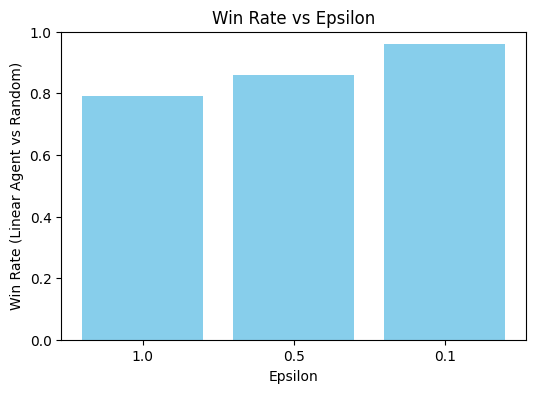

Ep 500: Wins 64, Losses 208, Epsilon 0.098
Weights: [-0.3    0.007  0.014 -0.001 -0.036 -0.039]
Ep 1000: Wins 69, Losses 206, Epsilon 0.095
Weights: [-0.348  0.014  0.038 -0.026 -0.038 -0.003]
Ep 1500: Wins 64, Losses 200, Epsilon 0.093
Weights: [-0.314 -0.001  0.019 -0.032 -0.005 -0.025]
Ep 2000: Wins 52, Losses 217, Epsilon 0.090
Weights: [-0.351  0.056 -0.078  0.01  -0.075 -0.005]
Ep 2500: Wins 84, Losses 208, Epsilon 0.088
Weights: [-0.243  0.049 -0.025  0.02  -0.07   0.034]
Ep 3000: Wins 81, Losses 205, Epsilon 0.086
Weights: [-0.388  0.11  -0.015 -0.036 -0.106 -0.012]


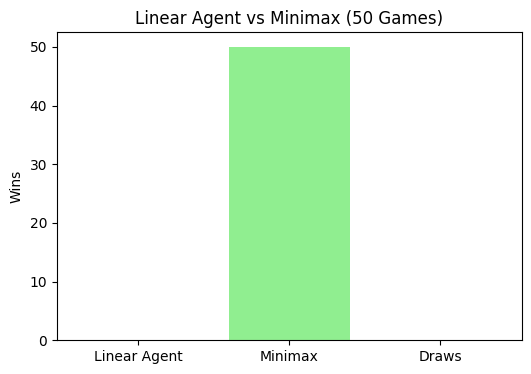

Episode 300: Win rate 0.80
Episode 600: Win rate 0.78
Episode 900: Win rate 0.74
Episode 1200: Win rate 0.86
Episode 1500: Win rate 0.76
Episode 1800: Win rate 0.78
Episode 2100: Win rate 0.74
Episode 2400: Win rate 0.78
Episode 2700: Win rate 0.84
Episode 3000: Win rate 0.74


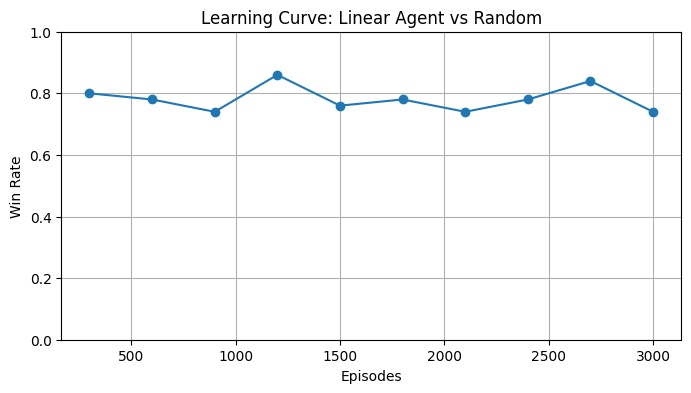

In [ ]:
# Cell 7 Experiments and Graphs
import matplotlib.pyplot as plt


# Experiment 1: Compare different epsilon values
epsilons = [1.0, 0.5, 0.1]
episodes = 2000
eval_games = 100

epsilon_win_rates = {}

for eps in epsilons:
    print(f"Training Linear Agent with epsilon={eps}")
    weights_eps = train(episodes=episodes, epsilon_start=eps)
    
    # Evaluate agent vs random
    wins = 0
    for _ in range(eval_games):
        env = Connect4()
        done = False
        turn = 0  # 0 = linear agent, 1 = random
        while not done:
            if turn == 0:
                action = linear_agent_move(env, weights_eps)
            else:
                action = random.choice(env.valid_actions())
            _, reward, done, _ = env.step(action)
            turn = 1 - turn
        if env.winner == 1:
            wins += 1
    win_rate = wins / eval_games
    epsilon_win_rates[eps] = win_rate
    print(f"Epsilon {eps} win rate: {win_rate:.2f}")

# Plot epsilon comparison
plt.figure(figsize=(6,4))
plt.bar([str(e) for e in epsilons], [epsilon_win_rates[e] for e in epsilons], color='skyblue')
plt.title("Win Rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Win Rate (Linear Agent vs Random)")
plt.ylim(0,1)
plt.show()

# --------------------------
# Experiment 2: Minimax vs Learned Agent (fixed)
# --------------------------
weights_trained = train(episodes=3000, epsilon_start=0.1)
games = 50
linear_wins = 0
minimax_wins = 0
draws = 0

for _ in range(games):
    env = Connect4()
    env.reset()
    done = False

    while not done:
        if env.current_player == 1:  # Linear Agent
            action = linear_agent_move(env, weights_trained)
        else:  # Minimax Agent
            res = minimax_agent(env, depth=2)
            if isinstance(res, tuple):
                action = res[1]  # pick the move, not the value
            else:
                action = res
        _, _, done, _ = env.step(action)

    if env.winner == 1:
        linear_wins += 1
    elif env.winner == -1:
        minimax_wins += 1
    else:
        draws += 1

# Plot comparison
plt.figure(figsize=(6,4))
plt.bar(["Linear Agent", "Minimax", "Draws"], [linear_wins, minimax_wins, draws], color='lightgreen')
plt.title("Linear Agent vs Minimax (50 Games)")
plt.ylabel("Wins")
plt.show()

# --------------------------
# Experiment 3: Learning Curve over Episodes
# --------------------------
episodes = 3000
eval_interval = 300
epsilon_start = 1.0
win_rates = []

weights = np.zeros(6)
epsilon_current = epsilon_start

for ep in range(1, episodes+1):
    env = Connect4()
    env.reset()
    done = False
    while not done:
        state_before = env.board.copy()
        action = choose_action(env, epsilon_current)
        _, reward, done, _ = env.step(action)
        state_after = env.board.copy()
        update(state_before, action, reward, state_after, done, 1)

        if not done:
            # Opponent move (random)
            opp_action = random.choice(env.valid_actions())
            _, _, done, _ = env.step(opp_action)
    # Decay epsilon
    epsilon_current = max(epsilon_min, epsilon_current * epsilon_decay)

    # Evaluate periodically
    if ep % eval_interval == 0:
        wins = 0
        eval_games = 50
        for _ in range(eval_games):
            env = Connect4()
            env.reset()
            done = False
            turn = 0
            while not done:
                if turn == 0:
                    action = linear_agent_move(env, weights)
                else:
                    action = random.choice(env.valid_actions())
                _, _, done, _ = env.step(action)
                turn = 1 - turn
            if env.winner == 1:
                wins += 1
        win_rate = wins / eval_games
        win_rates.append(win_rate)
        print(f"Episode {ep}: Win rate {win_rate:.2f}")

# Plot learning curve
plt.figure(figsize=(8,4))
plt.plot(range(eval_interval, episodes+1, eval_interval), win_rates, marker='o')
plt.title("Learning Curve: Linear Agent vs Random")
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.ylim(0,1)
plt.grid(True)
plt.show()